In [ ]:
pip install tensorflow

In [ ]:
pip install tflearn

     |████████████████████████████████| 112kB 9.6MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp36-none-any.whl size=127301 sha256=ca36db072ed800279f9b7b0a3b104c19bbbb91e3d8b8cd596c2177c22bbbc03c
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
import numpy as np
import pandas as pd
import cv2  # opencv ~=4
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from random import shuffle
from tqdm import tqdm 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


TRAIN_DIR = 'drive/My Drive/dogcat/train/'
TEST_DIR = 'drive/My Drive/dogcat/test/'

IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogvscat-{}-{}.model'.format(LR, '6conv-basic-video')

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [ ]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle (training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [ ]:
def process_test_data():
  testing_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img_num = img.split('.')[0]
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    testing_data.append([np.array(img), img_num])

  np.save('test_data.npy', testing_data)
  return testing_data


In [ ]:
train_data = create_train_data()

100%|██████████| 2000/2000 [17:56<00:00,  1.86it/s]


In [ ]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir ='log')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
  model.load(MODEL_NAME)
  print('model loaded!')


In [ ]:
train = train_data[:-500]
test = train_data[-500:]

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_X = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_Y = [i[1] for i in test]


In [ ]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_X}, {'targets': test_Y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 119  | total loss: 0.67294 | time: 0.282s
| Adam | epoch: 005 | loss: 0.67294 - acc: 0.5716 -- iter: 1472/1500
Training Step: 120  | total loss: 0.67384 | time: 1.296s
| Adam | epoch: 005 | loss: 0.67384 - acc: 0.5692 | val_loss: 0.67797 - val_acc: 0.5640 -- iter: 1500/1500
--


In [ ]:
model.save(MODEL_NAME)

INFO:tensorflow:/content/dogvscat-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 500/500 [00:01<00:00, 279.37it/s]


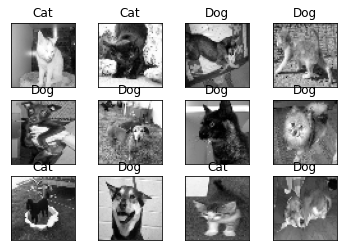

In [ ]:
import matplotlib.pyplot as plt

test_data = process_test_data()
#test_data = np.load('test_data.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
  #cat: [1,0]
  #dog: [0,1]

  img_num = data[1]
  img_data = data[0]

  y = fig.add_subplot(3,4,num+1)
  orig = img_data
  data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)

  model_out = model.predict([data])[0]

  if np.argmax(model_out) == 1: str_label = 'Dog'
  else: str_label = 'Cat'

  y.imshow(orig, cmap = 'gray')
  plt.title(str_label)
  y.axes.get_xaxis().set_visible(False)
  y.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
with open ('submission-file.csv', 'w') as f:
  f.write('id,label\n')

In [ ]:
with open ('submission-file.csv', 'a') as f:
  for data in tqdm (test_data):
      img_num = data[1]
      img_data = data[0]
      y = fig.add_subplot(3,4,num+1)
      orig = img_data
      data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
      model_out = model.predict([data])[0]
      f.write('{},{}\n'.format(img_num, model_out[1]))
      


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
100%|██████████| 500/500 [00:00<00:00, 599.21it/s]
